# Recap

We will go through the main issues you will face when working with Recurrent Neural Networks that are designed to deal with time-series

## Part 1: How to make a proper Time Series Split ?

Let's imagine your `data` as 2D array structured as follows

`data.shape = (n_timesteps, n_features)`

`features` can be separated into 3 categories
- targets
- past-covariates
- future-covariates

<img src='https://github.com/lewagon/data-images/blob/master/DL/time-series-covariates.png?raw=true'>

### 1.1) First, create many **FOLDS** for your cross-validation

`fold_1.shape = (n_timesteps_per_fold, n_features)`  as 2D arrays  
`fold_2.shape = (n_timesteps_per_fold, n_features)`  as 2D arrays

Always split your training set *chronologically before* your test set

👇 e.g. 4-time cross validation split

<img src='https://github.com/lewagon/data-images/blob/master/DL/rnn-2.png?raw=true'>

Create as many folds as needed to clearly test all type of past conditions 
(e.g crash markets periods 📉, bull-run markets 📈, flat markets 😴 etc...)

It's very common to have **hundreds of folds** in Time Series forecasting!

### 1.2) in each FOLD, and for each train or test SET, split your time series into different SEQUENCES of (observations, target)

<img src='https://github.com/lewagon/data-images/blob/master/DL/rnn-1.png?raw=true'>

Goal: create (`X_train`, `y_train`, `X_test`, `y_test`) containing all you need to train and test your model for this fold
  
- `X_train.shape = (n_samples, input_chunk_length, n_covariate_features)`
- `y_train.shape = (n_samples, output_chunk_length, n_targets)`

Notice that we now have 3D-arrays


💡 You can randomly sample or create them all sliding from left to right, with selected stride

<img src='https://github.com/lewagon/data-images/blob/master/DL/sequence-length.png?raw=true'>

### 3) 🚨 Beware of the **GAP** of length (horizon - 1) between each train & test sets in each fold to avoid data-leakage

<center><img src='https://github.com/lewagon/data-images/blob/master/DL/rnn-2.png?raw=true' width = 400 ></center>

👇 Below is a zoom inside **ONE SINGLE FOLD**

A gap of size `horizon - 1` is mandatory to reflect real situations:
- Here the forecast horizon is `4` days
- Let's say we want our train set to end by predicting day `10` based on days before `4, 5, 6`
- In a real situation we would need to **wait** for day `10` to discover the true value of `y` on which to finalize training
- Therefore, the test set can only start on day `10`, which is meant to predict `y_test = 10 + 4`

<span style='color:#2F8C41;font-size:20px'>horizon $h = 4$</span>

$$ \Large X^{t+\color{green}4} = f(X^t, X^{t-1}, X^{t-2}) $$

<img src='https://github.com/lewagon/data-images/blob/master/DL/rnn-3.png?raw=true'>

✅ Use [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html) `TimeSeriesSplit(n_splits = ..., gap=...)`

---

# Part 2: Air Pollution Solution

<img src='https://github.com/lewagon/data-images/blob/master/DL/rnn-4.png?raw=true'>

## 2.1 Data

❓ **Question** ❓ We will load the data from the third and fourth exercise. Load the data, and keep only the following columns :  `['pm2.5', 'TEMP', 'DEWP', 'PRES', 'Ir', 'Is', 'Iws']`

In [1]:
import pandas as pd

df = pd.read_csv('https://wagon-public-datasets.s3.amazonaws.com/deep_learning_datasets/air%20pollution.txt', index_col=[0])
df = df[['pm2.5', 'TEMP', 'DEWP', 'PRES', 'Ir', 'Is', 'Iws']]

In [2]:
df

,pm2.5,TEMP,DEWP,PRES,Ir,Is,Iws
No,,,,,,,
1,NaN,-11.0,-21,1021.0,0,0,1.79
2,NaN,-12.0,-21,1020.0,0,0,4.92
3,NaN,-11.0,-21,1019.0,0,0,6.71
4,NaN,-14.0,-21,1019.0,0,0,9.84
5,NaN,-12.0,-20,1018.0,0,0,12.97
...,...,...,...,...,...,...,...
43820,8.0,-2.0,-23,1034.0,0,0,231.97
43821,10.0,-3.0,-22,1034.0,0,0,237.78
43822,10.0,-3.0,-22,1034.0,0,0,242.70


❓ **Question** ❓ For the sake of simplicity, fill in the missing values with mean over the entire dataset.

In [3]:
df = df.fillna(df.mean())

In [26]:
df.describe()

,pm2.5,TEMP,DEWP,PRES,Ir,Is,Iws
count,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000
mean,98.613215,12.448521,1.817246,1016.447654,0.194916,0.052734,23.889140
std,89.853296,12.198613,14.433440,10.268698,1.415867,0.760375,50.010635
min,0.000000,-19.000000,-40.000000,991.000000,0.000000,0.000000,0.450000
25%,31.000000,2.000000,-10.000000,1008.000000,0.000000,0.000000,1.790000
50%,77.000000,14.000000,2.000000,1016.000000,0.000000,0.000000,5.370000
75%,132.000000,23.000000,15.000000,1025.000000,0.000000,0.000000,21.910000
max,994.000000,42.000000,28.000000,1046.000000,36.000000,27.000000,585.600000


Usually, in classic settings, there is multiple independent sequences $X$, each with a corresponding $y$.
However, if often happens that we don't have access to multiple sequences $X$, but to only one very long sequence as it is the case here. From that, experts usually split them into multiple sub-sequences.


❓ **Question** ❓ Write a function that is able to get a subsequence $X$ and a corresponding $y$ which corresponds to the air pollution **5 days** after the last observation. The length of the subsequence should be an argument of the function

In [4]:
import numpy as np

def subsample_sequence(df, length):
    # $CHALLENGIFY_BEGIN
    last_possible = df.shape[0] - length - 5
    
    random_start = np.random.randint(0, last_possible)
    X = df[random_start: random_start+length].values
    y = df.iloc[random_start+length+5]['pm2.5']
    # $CHALLENGIFY_END
    return X, y

subsample_sequence(df, 10)

(array([[3.100e+01, 3.200e+01, 1.800e+01, 9.980e+02, 0.000e+00, 0.000e+00,
         1.878e+01],
        [5.000e+01, 3.100e+01, 2.100e+01, 9.990e+02, 0.000e+00, 0.000e+00,
         2.280e+01],
        [5.900e+01, 2.900e+01, 2.200e+01, 1.000e+03, 0.000e+00, 0.000e+00,
         8.900e-01],
        [5.800e+01, 3.100e+01, 2.200e+01, 1.001e+03, 0.000e+00, 0.000e+00,
         4.920e+00],
        [2.700e+01, 2.800e+01, 1.900e+01, 1.000e+03, 0.000e+00, 0.000e+00,
         1.790e+00],
        [5.000e+01, 2.500e+01, 1.800e+01, 1.000e+03, 0.000e+00, 0.000e+00,
         4.920e+00],
        [3.000e+01, 2.400e+01, 1.900e+01, 1.000e+03, 0.000e+00, 0.000e+00,
         8.050e+00],
        [3.100e+01, 2.200e+01, 1.800e+01, 1.000e+03, 0.000e+00, 0.000e+00,
         1.207e+01],
        [2.600e+01, 2.200e+01, 1.800e+01, 1.000e+03, 0.000e+00, 0.000e+00,
         1.520e+01],
        [2.400e+01, 2.100e+01, 1.800e+01, 1.000e+03, 0.000e+00, 0.000e+00,
         1.699e+01]]),
 22.0)

❓ **Question** ❓ Given a list of integers, write a function that split the initial dataset as many times as there are integers in the list. The length of each sequence is the value of the integer in that list.

In [5]:
def get_X_y(df, length_of_observations):
    X, y = [], []
    # $CHALLENGIFY_BEGIN
    for length in length_of_observations:
        xi, yi = subsample_sequence(df, length)
        X.append(xi)
        y.append(yi)
    # $CHALLENGIFY_END
    return X, y

length_of_observations = np.random.randint(10, 15, 100)
X, y = get_X_y(df, length_of_observations)

❓ **Question** ❓ If you split into a train and test set _after_ creating the shorter sequences, you risk having same values in the train and test set, which corresponds to data leakage. Therefore, split your train and test set and then, get your training and test sequences - and the corresponding output.

❗️ Beware of the gap required between train and test!

In [8]:
horizon = 5
gap = horizon - 1

len_ = int(0.8*df.shape[0])

df_train = df[:len_]
df_test = df[len_+gap:]

In [9]:
length_of_observations = np.random.randint(10, 15, 100)
X_train, y_train = get_X_y(df, length_of_observations)

length_of_observations = np.random.randint(10, 15, 100)
X_test, y_test = get_X_y(df, length_of_observations)

Each sequence has a certain number of observations. But across sequences, this number of observations is not the same. Because the Neural Network is trained with *batches* of data, you must ensure that, once the sequences are concatenated, they can be represented as a tensor. This operation is called the padding

❓ From the four sequences above, return a padded tensor (with the dedicated Keras function) and plot it.

In [10]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
# $CHALLENGIFY_BEGIN
X_train_pad = pad_sequences(X_train, dtype='float32', value=-1)
# $CHALLENGIFY_END

X_train_pad.shape

(100, 14, 7)

## Model

As you added data to your input just for computational reasons, your model has to know which one is useful or not. 

❓ Initialize a model and add a masking layer so that your model does not take the padded values into account. You have to tell which value you used for the padding

In [11]:
from tensorflow.keras import Sequential, layers
from tensorflow.keras.layers import Normalization

In [20]:
normalizer = Normalization()
normalizer.adapt(X_train_pad)

model = Sequential()
model.add(normalizer)
model.add(layers.Masking(mask_value=-1))
model.add(layers.LSTM(10, activation='tanh'))
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='linear'))

In [21]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, None, 7)          15        
 ion)                                                            
                                                                 
 masking_1 (Masking)         (None, None, 7)           0         
                                                                 
 lstm_1 (LSTM)               (None, 10)                720       
                                                                 
 dense_2 (Dense)             (None, 10)                110       
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                                 
Total params: 856
Trainable params: 841
Non-trainable params: 15
_______________________________________________________

❓ Compile your model

In [22]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.metrics import MAPE
model.compile(loss='mse', optimizer=RMSprop(learning_rate=0.01), metrics=MAPE)

❓ Train your model on the data

In [23]:
import numpy as np

history = model.fit(X_train_pad, np.array(y_train), epochs=100, batch_size=64, validation_split=0.3)

Epoch 1/100
2/2 [==============================] - 4s 1s/step - loss: 27065.4180 - mean_absolute_percentage_error: 99.8779 - val_loss: 16562.6680 - val_mean_absolute_percentage_error: 98.4985
Epoch 2/100
2/2 [==============================] - 0s 26ms/step - loss: 26888.0547 - mean_absolute_percentage_error: 99.0281 - val_loss: 16383.2646 - val_mean_absolute_percentage_error: 96.2971
Epoch 3/100
2/2 [==============================] - 0s 28ms/step - loss: 26598.7246 - mean_absolute_percentage_error: 97.5555 - val_loss: 16066.3779 - val_mean_absolute_percentage_error: 92.1551
Epoch 4/100
2/2 [==============================] - 0s 28ms/step - loss: 26162.3086 - mean_absolute_percentage_error: 94.9189 - val_loss: 15663.6094 - val_mean_absolute_percentage_error: 85.7176
Epoch 5/100
2/2 [==============================] - 0s 31ms/step - loss: 25670.1992 - mean_absolute_percentage_error: 91.4122 - val_loss: 15320.0303 - val_mean_absolute_percentage_error: 82.5309
Epoch 6/100
2/2 [===============

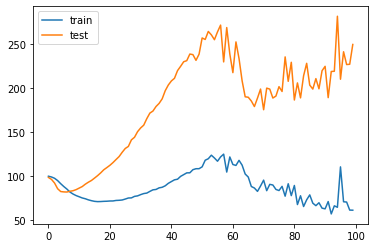

In [25]:
import matplotlib.pyplot as plt
plt.plot(history.history['mean_absolute_percentage_error'])
plt.plot(history.history['val_mean_absolute_percentage_error'])
plt.legend(['train', 'test'])